In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation, metrics
%matplotlib inline

/home/shyam/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Feature Engineering Using Clustering Methods

In [2]:
iris = datasets.load_iris()

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Putting the data into a nice dataframe

In [5]:
df = pd.DataFrame({"SepalLength":iris.data[:,0],"SepalWidth":iris.data[:,1],"PetalLength":iris.data[:,2],"PetalWidth":iris.data[:,3],"FlowerClass":iris.target})

In [6]:
df.head(5)

,FlowerClass,PetalLength,PetalWidth,SepalLength,SepalWidth
0,0,1.4,0.2,5.1,3.5
1,0,1.4,0.2,4.9,3.0
2,0,1.3,0.2,4.7,3.2
3,0,1.5,0.2,4.6,3.1
4,0,1.4,0.2,5.0,3.6


In [7]:
X = df[["PetalLength","PetalWidth","SepalLength","SepalWidth"]]

First thing: pairwise scatter plot

Seems like the features are very linear related.

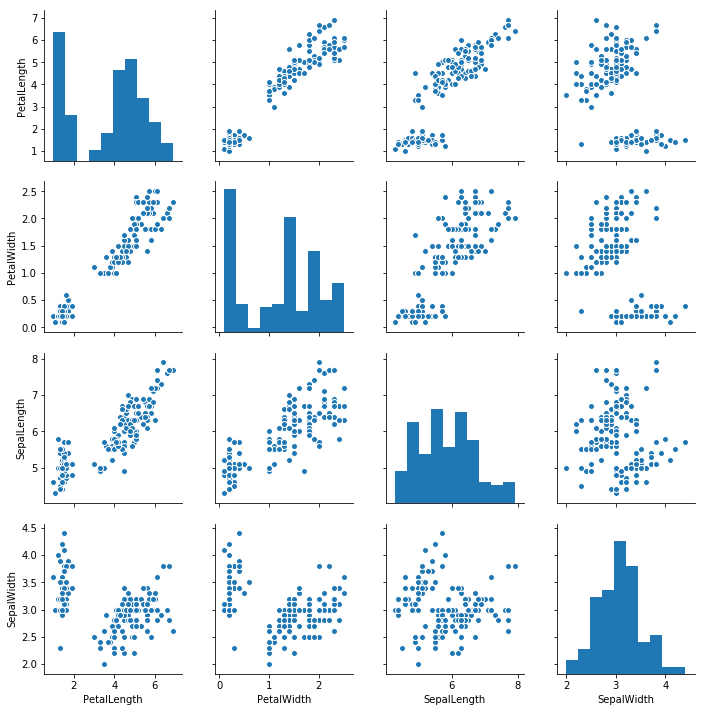

In [8]:
sns.pairplot(X)

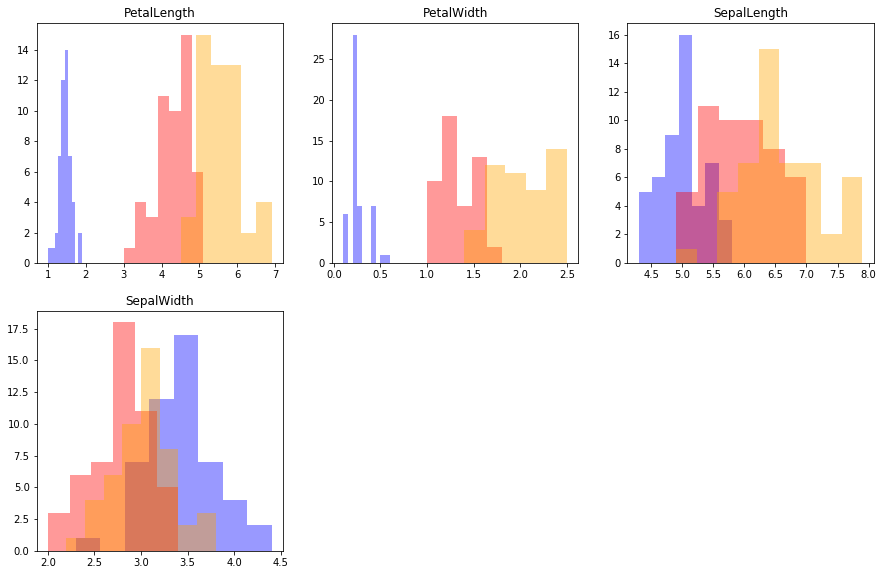

In [9]:
sert = df[df["FlowerClass"] == 0]
veris = df[df["FlowerClass"] == 1]
virg = df[df["FlowerClass"] == 2]
fig = plt.figure()
plt.figure(figsize=[15,15])
ax = plt.subplot(331)
ax.set_title("PetalLength")
sns.distplot(sert['PetalLength'].dropna().values,kde=False, color="blue")
sns.distplot(veris['PetalLength'].dropna().values,kde=False, color="red")
sns.distplot(virg['PetalLength'].dropna().values,kde=False, color="orange")
ax = plt.subplot(332)
ax.set_title("PetalWidth")
sns.distplot(sert['PetalWidth'].dropna().values,kde=False, color="blue")
sns.distplot(veris['PetalWidth'].dropna().values,kde=False, color="red")
sns.distplot(virg['PetalWidth'].dropna().values,kde=False, color="orange")
ax = plt.subplot(333)
ax.set_title("SepalLength")
sns.distplot(sert['SepalLength'].dropna().values,kde=False, color="blue")
sns.distplot(veris['SepalLength'].dropna().values,kde=False, color="red")
sns.distplot(virg['SepalLength'].dropna().values,kde=False, color="orange")
ax = plt.subplot(334)
ax.set_title("SepalWidth")
sns.distplot(sert['SepalWidth'].dropna().values,kde=False, color="blue")
sns.distplot(veris['SepalWidth'].dropna().values,kde=False, color="red")
sns.distplot(virg['SepalWidth'].dropna().values,kde=False, color="orange")

# sns.distplot(sert['PetalLength'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
#             axlabel='Age')

In [10]:
X = iris.data

In [11]:
X = X[:,2:]

SepalWidth and SepalLength seem to overlap for all the classes, so they arent great features for us to cluster.. The PetalLength and PetalWidth for each class seem to have clear different ranges in values.

## Fuzzy Kmeans to cluster based on Sepal Width/Length

I thought it'd be pretty fun to make this from scratch. 
Referenced https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/cmeans.html

In [12]:
class FuzzyKmeans():
    
    def __init__(self,X):
        self.X = X
        
    def calculate_centers(self,U,m):
        X = self.X
        ones = np.ones(X.shape[0]).reshape((X.shape[0],1))
        denom = (1/(U**m).dot(ones)).reshape(U.shape[0],)
        diagonal = np.diag(denom)
        centers = diagonal.dot((U**m).dot(X))
        return centers
        
    def calculate_fuzzy(self,centers,m):
        m = 2/(m-1)
        X = self.X
        us = np.ones(shape=(centers.shape[0],1))
        ones = np.ones(shape=(1,centers.shape[0]))
        for i in range(X.shape[0]):
            row = X[i].reshape(X.shape[1],1)
            row = row.dot(ones).T - centers
            norms = np.linalg.norm(row,2,axis=1).reshape(centers.shape[0],1)
            norms = (norms.dot(1/norms.T))**m
            sums = 1/np.sum(norms,axis=1).reshape(norms.shape[0],1)
            us = np.column_stack((us,sums))

        return us[:,1:]
        
    def cluster(self,m,k,exit,seed,argmax=False): 
        """
        Main clustering function
        m is the degree of uncertainty, (fuzziness of cluster)
        k is the number of clusters
        exit is the exit criteria 
        set argmax = True for normal K-means
        """
        np.random.seed(seed)
        U = np.random.uniform(0,1,size=(k,X.shape[0])) #initialize cluster probabilities
        centers = self.calculate_centers(U,m)
        newcenters = 2*centers
        while np.linalg.norm((centers - newcenters),2) >= exit:
            newcenters = centers
            U = self.calculate_fuzzy(centers,m)
            centers = self.calculate_centers(U,m)
        if argmax:
            return np.argmax(U,axis=0).T
        return U.T

In [13]:
fuzzy = FuzzyKmeans(X)

We'll use three clusters for 3 classes, and use either the fuzzy probs or the maximum values(equivalent to just k-means)

Fuzzy probs:

In [14]:
fuzzy_clusters = fuzzy.cluster(2,3,0.02,1)

In [15]:
fuzzy_clusters[:10,:]

array([[3.56225843e-04, 7.73647474e-04, 9.98870127e-01],
       [3.56225843e-04, 7.73647474e-04, 9.98870127e-01],
       [1.43706995e-03, 3.06188483e-03, 9.95501045e-01],
       [1.45021945e-04, 3.21307792e-04, 9.99533670e-01],
       [3.56225843e-04, 7.73647474e-04, 9.98870127e-01],
       [3.99244091e-03, 9.37215541e-03, 9.86635404e-01],
       [3.81455947e-04, 8.33191366e-04, 9.98785353e-01],
       [1.45021945e-04, 3.21307792e-04, 9.99533670e-01],
       [3.56225843e-04, 7.73647474e-04, 9.98870127e-01],
       [1.06694872e-03, 2.34668661e-03, 9.96586365e-01]])

Kmeans clusters:

In [16]:
kmeans_clusters = fuzzy.cluster(2,3,0.02,1,True).reshape(X.shape[0],1)

In [17]:
kmeans_clusters[:10]

array([[2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]])

## Logistic Regression to predict the classes

Here we'll compare the predictive power of models that use all the features, just the fuzzy probabilities, and substituting petal length/width with the kmeans clusters

In [18]:
lr = LogisticRegression()

In [19]:
newd = np.array(df)

In [20]:
newd = newd[:,1:]

In [21]:
newd[:10,:]

array([[1.4, 0.2, 5.1, 3.5],
       [1.4, 0.2, 4.9, 3. ],
       [1.3, 0.2, 4.7, 3.2],
       [1.5, 0.2, 4.6, 3.1],
       [1.4, 0.2, 5. , 3.6],
       [1.7, 0.4, 5.4, 3.9],
       [1.4, 0.3, 4.6, 3.4],
       [1.5, 0.2, 5. , 3.4],
       [1.4, 0.2, 4.4, 2.9],
       [1.5, 0.1, 4.9, 3.1]])

In [22]:
y = iris.target

Model with original features

In [23]:
predicted = cross_validation.cross_val_predict(LogisticRegression(),newd,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.9533333333333334

A simple logistic regression model can achieve 95% accuracy

Model with just Petal Length/Width

In [24]:
predicted = cross_validation.cross_val_predict(LogisticRegression(),newd[:,:2],y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.86

Seems like just Petal Length/Width are not enough to predict the type of flower

Model with just fuzzy probs

In [25]:
predicted = cross_validation.cross_val_predict(LogisticRegression(),fuzzy_clusters,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.96

This is probably due to the fact that the 3 classes clearly have different value ranges for petal length & width so the cluster probs work very well in predicting flower class. Still pretty cool.

Model with just kmeans cluster values

In [26]:
predicted = cross_validation.cross_val_predict(LogisticRegression(),kmeans_clusters,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.94

This is pretty cool. By just using the clusters we've reduced the rank of our data to 1 and still managed to achieve 94% accuracy 

Model with kmeans clusters in replacement of Petal Width/Length

In [27]:
newx = np.column_stack((kmeans_clusters,newd[:,2:]))
predicted = cross_validation.cross_val_predict(LogisticRegression(),newx,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.94

adding sepal width/length doesn't seem to improve the accuracy

Model with fuzzy probs in addition to original variables

In [28]:
newx = np.column_stack((fuzzy_clusters,newd))
predicted = cross_validation.cross_val_predict(LogisticRegression(),newx,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.9533333333333334

Seems we can't improve our accuracy by just adding the cluster probabilities 

Model with kmeans cluster vals in addition to original variables

In [29]:
newx = np.column_stack((kmeans_clusters,newd))
predicted = cross_validation.cross_val_predict(LogisticRegression(),newx,y,cv=10)
metrics.accuracy_score(iris.target,predicted)

0.94

Seems like adding features to the Kmeans model doesn't improve its accuracy

### From our results we can see that interestingly enough, the model with just the fuzzy cluster probabilities generated from performing fuzzy kmeans on Petal Length and Petal Width resulted in the best predictive model. This is pretty cool because this means that even though we reduced our data matrix to 3 dimensions we were able to capture enough of the trend to give accurate predictions. This is probably due to the fact that Petal Length/Width have very clearly separated ranges of values for each class, making it easy to cluster the classes together using them. That being said, the results were pretty unexpected and cool.